<a href="https://colab.research.google.com/github/dru-44/Project2022/blob/main/Land_Cover_Classification(3D_CNN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [65]:
pip install tensorboard

In [21]:
pip install rasterio

In [22]:

!pip install earthpy gdal

     |████████████████████████████████| 1.4 MB 4.2 MB/s 
     |████████████████████████████████| 1.0 MB 37.1 MB/s 
     |████████████████████████████████| 16.7 MB 393 kB/s 
     |████████████████████████████████| 6.3 MB 38.8 MB/s 


In [74]:
from glob import glob

import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
import datetime
import rasterio as rio
from rasterio.plot import plotting_extent
from rasterio.plot import show
from rasterio.plot import reshape_as_raster, reshape_as_image

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from scipy.io import loadmat
from sklearn.metrics import classification_report, accuracy_score
from sklearn.decomposition import PCA
import plotly.graph_objects as go
import tensorflow as tf
import pandas as pd
import seaborn as sns

In [24]:



S_sentinel_bands = glob("/content/drive/MyDrive/sd/*B?*.tiff")
S_sentinel_bands.sort()



In [25]:
S_sentinel_bands

['/content/drive/MyDrive/sd/2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B01_(Raw).tiff',
 '/content/drive/MyDrive/sd/2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B02_(Raw).tiff',
 '/content/drive/MyDrive/sd/2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B03_(Raw).tiff',
 '/content/drive/MyDrive/sd/2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B04_(Raw).tiff',
 '/content/drive/MyDrive/sd/2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B05_(Raw).tiff',
 '/content/drive/MyDrive/sd/2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B06_(Raw).tiff',
 '/content/drive/MyDrive/sd/2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B07_(Raw).tiff',
 '/content/drive/MyDrive/sd/2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B08_(Raw).tiff',
 '/content/drive/MyDrive/sd/2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B09_(Raw).tiff',
 '/content/drive/MyDrive/sd/2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B11_(Raw).tiff',
 '/content/drive/MyDrive/sd/2020-01-27-00_00_2020-01-27-23_5

In [26]:
l = []
for i in S_sentinel_bands:
  with rio.open(i, 'r') as f:
    l.append(f.read(1))

# Data
arr_st = np.stack(l)

In [27]:

# Ground Truth
y_data = loadmat('/content/drive/MyDrive/sd/Sundarbands_gt.mat')['gt']

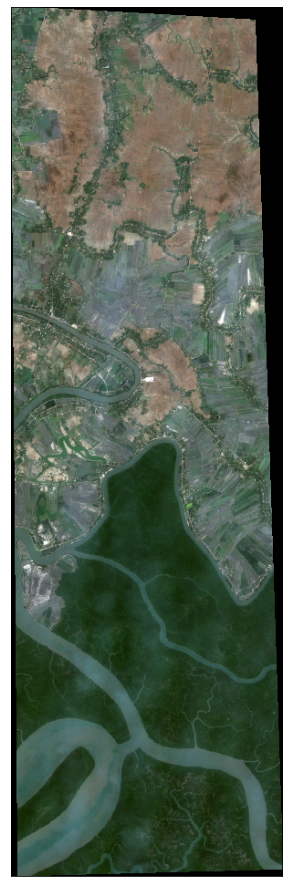

In [32]:
ep.plot_rgb(
    arr_st,
    rgb=(3, 2, 1),
    stretch=True,
    str_clip=0.02,
    figsize=(12, 16),
    # title="RGB Composite Image with Stretch Applied",
)

plt.show()


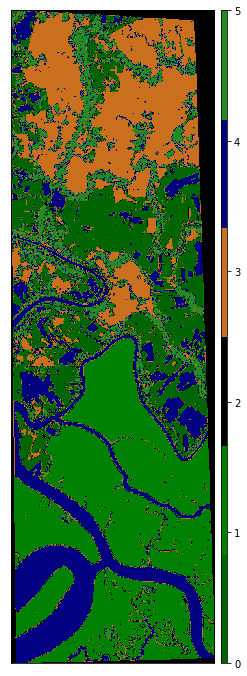

In [31]:
# Visualize Groundtruth

ep.plot_bands(y_data, 
              cmap=ListedColormap(['darkgreen', 'green', 'black', 
                                   '#CA6F1E', 'navy', 'forestgreen']))
plt.show()

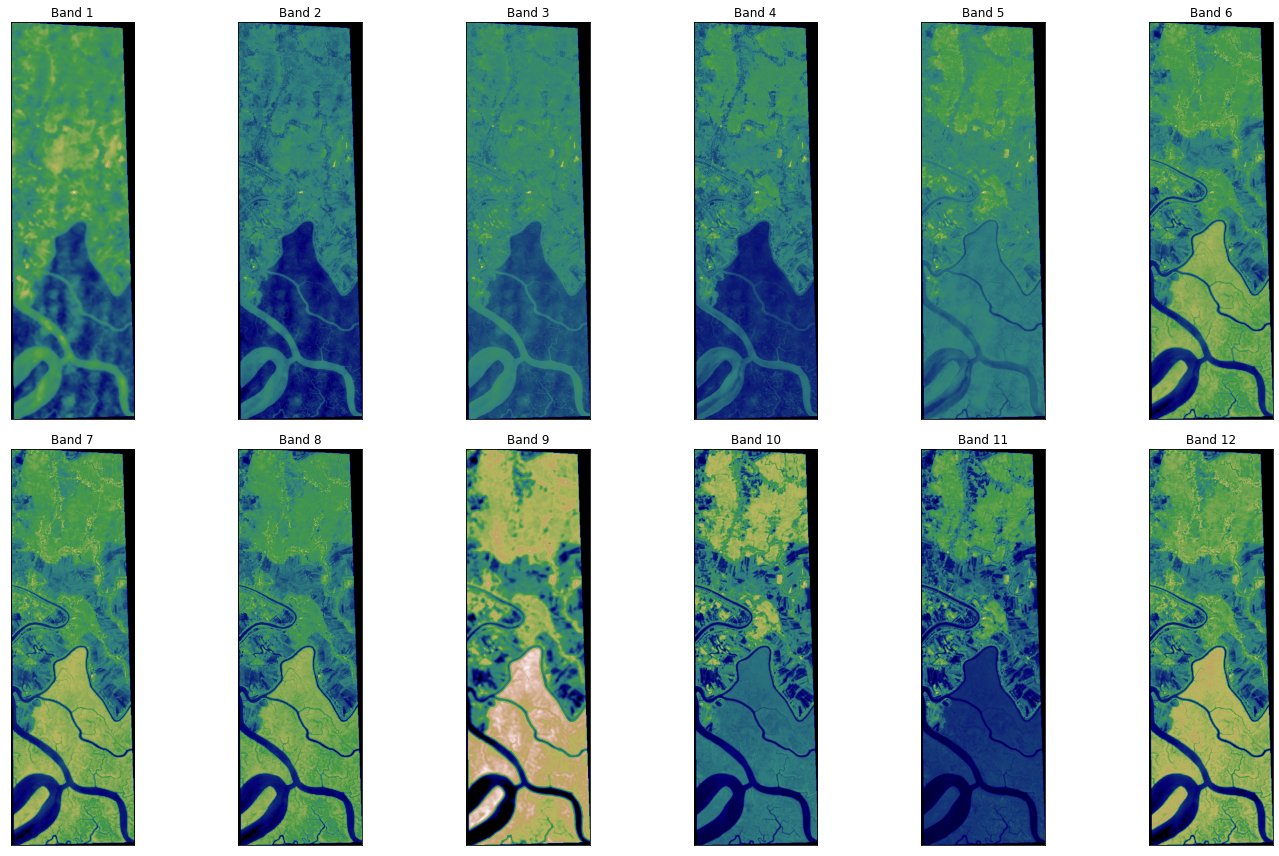

In [33]:

ep.plot_bands(arr_st, 
              cmap = 'gist_earth', 
              figsize = (20, 12), 
              cols = 6, 
              cbar = False)
plt.show()

create three-dimensional patches of the Sundarbans satellite image by applying Principal Component Analysis(PCA) to the data. The below code is used to create functions for implementing PCA, creating 3D patches, and to split data into train and test data in the ratio of 70:30. After splitting the data the train and test labels are one-hot encoded using to_categorical() method from tensorflow.keras package.



In [45]:
def applyPCA(X, numComponents=75):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca

def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

def createImageCubes(X, y, windowSize=5, removeZeroLabels = False):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

def splitTrainTestSet(X, y, testRatio, randomState=42):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState, stratify=y)
    return X_train, X_test, y_train, y_test
  
## GLOBAL VARIABLES
dataset = 'SB'
test_size = 0.30
windowSize = 15
MODEL_NAME = 'Sundarbans'
path = '/content/drive/MyDrive/sd/'

X_data = np.moveaxis(arr_st, 0, -1)
y_data = loadmat('/content/drive/MyDrive/sd/Sundarbands_gt.mat')['gt']

# Apply PCA
K = 5
X,pca = applyPCA(X_data,numComponents=K)

print(f'Data After PCA: {X.shape}')

# Create 3D Patches
X, y = createImageCubes(X, y_data, windowSize=windowSize)
print(f'Patch size: {X.shape}')

# Split train and test
X_train, X_test, y_train, y_test = splitTrainTestSet(X, y, testRatio = test_size)

X_train = X_train.reshape(-1, windowSize, windowSize, K, 1)
X_test = X_test.reshape(-1, windowSize, windowSize, K, 1)

# One Hot Encoding
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

print(f'Train: {X_train.shape}\nTest: {X_test.shape}\nTrain Labels: {y_train.shape}\nTest Labels: {y_test.shape}')

Data After PCA: (954, 298, 5)
Patch size: (284292, 15, 15, 5)
Train: (199004, 15, 15, 5, 1)
Test: (85288, 15, 15, 5, 1)
Train Labels: (199004, 6)
Test Labels: (85288, 6)


CNN Model

In [60]:
S = windowSize
L = K
output_units = y_train.shape[1]

## input layer
input_layer = tf. keras.Input((S, S, L, 1))

## convolutional layers
conv_layer1 = tf.keras.layers.Conv3D(filters=16, kernel_size=(2, 2, 3), activation='relu')(input_layer)
conv_layer2 = tf.keras.layers.Conv3D(filters=32, kernel_size=(2, 2, 3), activation='relu')(conv_layer1)
conv2d_shape = conv_layer2.shape
conv_layer3 = tf.keras.layers.Reshape((conv2d_shape[1], conv2d_shape[2], conv2d_shape[3]*conv2d_shape[4]))(conv_layer2)
conv_layer4 = tf.keras.layers.Conv2D(filters=64, kernel_size=(2,2), activation='relu')(conv_layer3)

flatten_layer = tf.keras.layers.Flatten()(conv_layer4)

## fully connected layers
dense_layer1 = tf.keras.layers.Dense(128, activation='relu')(flatten_layer)
dense_layer1 = tf.keras.layers.Dropout(0.4)(dense_layer1)
dense_layer2 = tf.keras.layers.Dense(64, activation='relu')(dense_layer1)
dense_layer2 = tf.keras.layers.Dropout(0.4)(dense_layer2)
dense_layer3 = tf.keras.layers.Dense(20, activation='relu')(dense_layer2)
dense_layer3 = tf.keras.layers.Dropout(0.4)(dense_layer3)
output_layer = tf.keras.layers.Dense(units=output_units, activation='softmax')(dense_layer3)
# define the model with input layer and output layer
model = tf.keras.Model(name = dataset+'_Model' , inputs=input_layer, outputs=output_layer)

model.summary()

Model: "SB_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 15, 15, 5, 1)]    0         
                                                                 
 conv3d_16 (Conv3D)          (None, 14, 14, 3, 16)     208       
                                                                 
 conv3d_17 (Conv3D)          (None, 13, 13, 1, 32)     6176      
                                                                 
 reshape_4 (Reshape)         (None, 13, 13, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 12, 12, 64)        8256      
                                                                 
 flatten_3 (Flatten)         (None, 9216)              0         
                                                                 
 dense_5 (Dense)             (None, 128)               117

# Training

In [68]:
# Compile
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

# Callbacks
logdir = path+"logs/" +model.name+'_'+datetime.datetime.now().strftime("%d:%m:%Y-%H:%M:%S")

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

es = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',
                   min_delta = 0,
                   patience = 1,
                   verbose = 1,
                   restore_best_weights = True)

checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath = 'Test_Model.h5', 
                             monitor = 'val_loss', 
                             mode ='min', 
                             save_best_only = True,
                             verbose = 1)
# Fit
history = model.fit(x=X_train, y=y_train, 
                    batch_size=1024*6, epochs=6, 
                    validation_data=(X_test, y_test), callbacks = [tensorboard_callback, es, checkpoint])


Epoch 1/6
33/33 [==============================] - ETA: 0s - loss: 0.9899 - accuracy: 0.6057
Epoch 1: val_loss improved from inf to 0.38266, saving model to Pavia_University_Model.h5
33/33 [==============================] - 212s 6s/step - loss: 0.9899 - accuracy: 0.6057 - val_loss: 0.3827 - val_accuracy: 0.8782
Epoch 2/6
33/33 [==============================] - ETA: 0s - loss: 0.5123 - accuracy: 0.8158
Epoch 2: val_loss improved from 0.38266 to 0.22822, saving model to Pavia_University_Model.h5
33/33 [==============================] - 211s 6s/step - loss: 0.5123 - accuracy: 0.8158 - val_loss: 0.2282 - val_accuracy: 0.9225
Epoch 3/6
33/33 [==============================] - ETA: 0s - loss: 0.3655 - accuracy: 0.8750
Epoch 3: val_loss improved from 0.22822 to 0.18110, saving model to Pavia_University_Model.h5
33/33 [==============================] - 187s 6s/step - loss: 0.3655 - accuracy: 0.8750 - val_loss: 0.1811 - val_accuracy: 0.9350
Epoch 4/6
33/33 [==============================] - ET

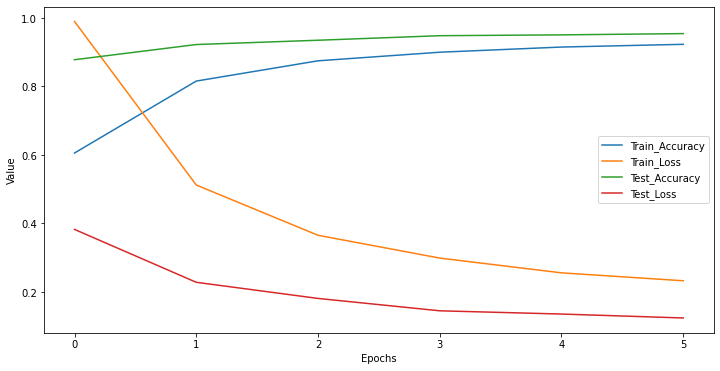

In [71]:
history = pd.DataFrame(history.history)

plt.figure(figsize = (12, 6))
plt.plot(range(len(history['accuracy'].values.tolist())), history['accuracy'].values.tolist(), label = 'Train_Accuracy')
plt.plot(range(len(history['loss'].values.tolist())), history['loss'].values.tolist(), label = 'Train_Loss')
plt.plot(range(len(history['val_accuracy'].values.tolist())), history['val_accuracy'].values.tolist(), label = 'Test_Accuracy')
plt.plot(range(len(history['val_loss'].values.tolist())), history['val_loss'].values.tolist(), label = 'Test_Loss')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.show()

# Results
The CNN model after training has 95.60% accuracy, Let’s see the confusion matrix which is a tabular representation often used to describe the performance of a classification model (or “classifier”) on a set of test data for which the true values are known.

In [81]:

pred = model.predict(X_test, batch_size=1204*6, verbose=1)

plt.figure(figsize = (10,7))

classes = [f'Class-{i}' for i in range(1, 7)]





12/12 [==============================] - 42s 4s/step


<Figure size 720x504 with 0 Axes>

In [101]:
from tensorflow.python.ops.numpy_ops import np_config
import tensorflow.experimental.numpy as tnp       
tnp.experimental_enable_numpy_behavior()
mat = tf.math.confusion_matrix(np.argmax(y_test, 1),
                            np.argmax(pred, 1))

#mat=mat.astype(tnp.float32)
df_cm = pd.DataFrame(mat, index = classes, columns = classes)



In [106]:
def my_func(arg):
  arg = tf.convert_to_tensor(arg, dtype=tf.float32)
  return arg

In [110]:
#mat=my_func(mat)
#mat=mat.astype(tnp.float32)
mat

AttributeError: ignored

TypeError: ignored

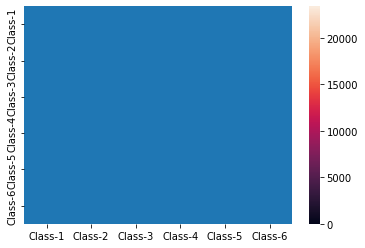

In [88]:
sns.heatmap(df_cm, annot=True, fmt='d')

plt.show()

# classification report 

In [111]:
# Classification Report
print(classification_report(np.argmax(y_test, 1),
                            np.argmax(pred, 1),
      target_names = [f'Class-{i}' for i in range(1, 7)]))

              precision    recall  f1-score   support

     Class-1       0.92      0.95      0.94     16222
     Class-2       0.98      0.99      0.99     23570
     Class-3       1.00      1.00      1.00      6095
     Class-4       0.95      0.97      0.96     16790
     Class-5       0.96      0.97      0.97     13545
     Class-6       0.90      0.78      0.84      9066

    accuracy                           0.95     85288
   macro avg       0.95      0.94      0.95     85288
weighted avg       0.95      0.95      0.95     85288



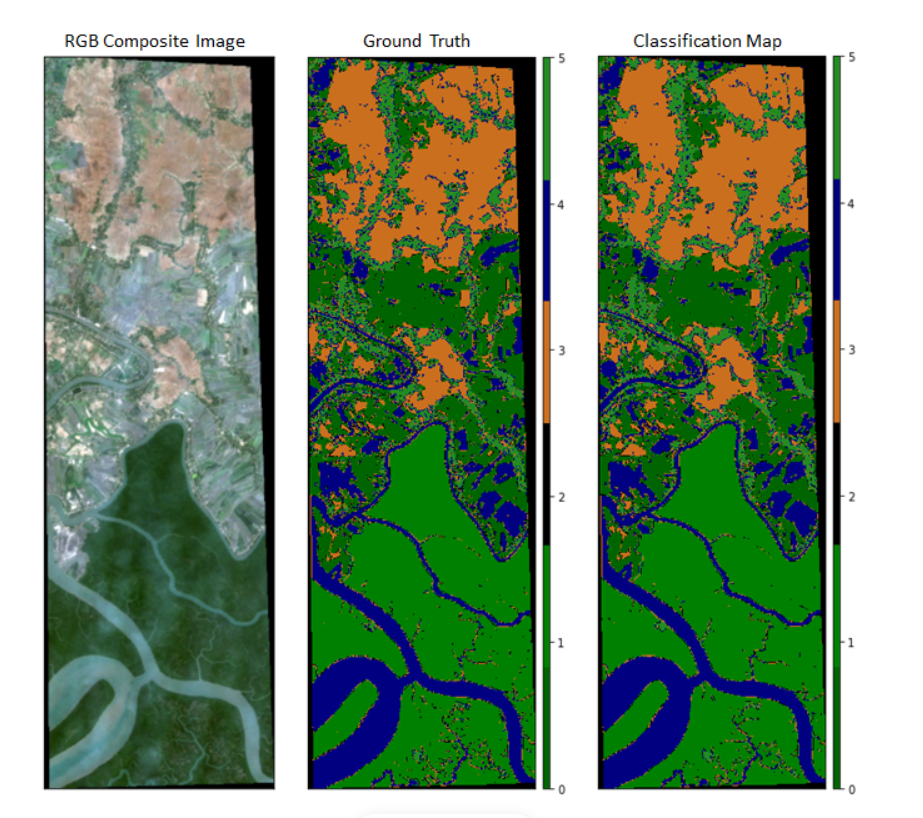